In [52]:
import numpy as np
from scipy.special import logit, expit
from scipy.special import digamma, polygamma
from scipy.optimize import fsolve

from scipy import stats

def find_logbeta_params(mean_logprob, var_logprob):
    def equations(vars):
        alpha, beta = vars
        # Mean equation
        eq1 = digamma(alpha) - digamma(alpha + beta) - mean_logprob
        # Variance equation
        eq2 = polygamma(1, alpha) - polygamma(1, alpha + beta) - var_logprob
        return [eq1, eq2]
    
    # Initial guess for α,β
    alpha0, beta0 = 1.0, 1.0
    alpha, beta = fsolve(equations, [alpha0, beta0])
    
    return alpha, beta

def logbeta_logprobs(mean_logprob, var_logprob, n_samples=10000):
    alpha, beta = find_logbeta_params(mean_logprob, var_logprob)
    probs = stats.beta.rvs(alpha, beta, size=n_samples)
    logprobs = np.log(probs)
    
    print(f"Fitted alpha, beta: {alpha:.3f}, {beta:.3f}")
    print(f"Target mean, var: {mean_logprob:.3f}, {var_logprob:.3f}")
    print(f"Achieved mean, var: {np.mean(logprobs):.3f}, {np.var(logprobs):.3f}")
    
    return logprobs
def compute_p2(p1, var_logprob, n, num_samples=10000):
    # Validate p1 is between 0 and 1
    if not 0 <= p1 <= 1:
        raise ValueError("p1 must be between 0 and 1")
    

    p11 = logbeta_logprobs(p1, var_logprob, num_samples)

    
    # Compute p11 and p12
    p11 = expit(logit(p1) + epsilon1)
    p12 = expit(logit(p1) + epsilon2)
    
    # Compute p2
    p2 = p11 * p12 + (1 - p11) / n
    
    return p2, p11, p12

In [2]:
def old_loss_two_hop(p1, n=100):
    return p1**2 + ((1-p1)**2) / (n-1)


def better_loss_two_hop(p1, n=100):
    return p1**2 + (1-p1) / n




In [55]:
p_1 = 0.0625

old_loss_two_hop(p_1, 10000), better_loss_two_hop(p_1, 10000), compute_p2(p_1, np.abs(logit(p_1))/4, 10000)[0].mean(), compute_p2(p_1, np.abs(logit(p_1))/4, 10000)[1].mean(), compute_p2(p_1, np.abs(logit(p_1))/4, 10000)[2].mean()


(0.003994149414941494,
 0.004,
 0.005664439517671612,
 0.0748176954313564,
 0.07419483546284834)

In [38]:
from scipy import optimize

def find_p1(target_p2, sigma, n, num_samples=10000):
    def objective(p1):
        np.random.seed(42)  # Fix seed for consistent optimization
        p2_samples = compute_p2(p1[0], sigma, n, num_samples)
        return np.abs(np.mean(p2_samples) - target_p2)
    
    # Try multiple starting points
    best_result = None
    best_score = float('inf')
    
    for start in [0.1, 0.3, 0.5, 0.7, 0.9]:
        result = optimize.minimize(
            objective, 
            x0=[start],
            bounds=[(0, 1)],
            method='L-BFGS-B',
            options={'ftol': 1e-8}
        )
        
        if result.fun < best_score:
            best_score = result.fun
            best_result = result
    
    return best_result.x[0]

# Example usage
target_p2 = 0.15
sigma = 1.0
n = 10000
estimated_p1 = find_p1(target_p2, sigma, n)
print(f"Estimated p1: {estimated_p1:.4f}, sqrt p2: {np.sqrt(target_p2):.4f}")

Estimated p1: 0.3640, sqrt p2: 0.3873


In [41]:
logit(0.25)

-1.0986122886681098

In [58]:
def explore_logbeta_bounds(mean_logprob):
    # Try a range of alpha values
    alphas = np.logspace(-2, 4, 100)
    vars = []
    for alpha in alphas:
        # For each alpha, find beta that gives our target mean
        def mean_eq(beta):
            return digamma(alpha) - digamma(alpha + beta) - mean_logprob
        
        try:
            beta = fsolve(mean_eq, [1.0])[0]
            if beta > 0:  # Valid beta only
                var = polygamma(1, alpha) - polygamma(1, alpha + beta)
                vars.append(var)
        except:
            continue
    
    if vars:
        print(f"For mean_logprob = {mean_logprob:.3f}")
        print(f"Min variance: {min(vars):.3f}")
        print(f"Max variance: {max(vars):.3f}")
        return min(vars), max(vars)
    return None

# Test some means
for mean in [-0.01,-0.5, -1.0, -2.0, -3.0, -4.0]:
    explore_logbeta_bounds(mean)

For mean_logprob = -0.010
Min variance: 0.000
Max variance: 1.739
For mean_logprob = -0.500
Min variance: 0.000
Max variance: 86.706
For mean_logprob = -1.000
Min variance: 0.000
Max variance: 172.913
For mean_logprob = -2.000
Min variance: 0.000
Max variance: 343.826
For mean_logprob = -3.000
Min variance: 0.000
Max variance: 334.176
For mean_logprob = -4.000
Min variance: 0.000
Max variance: 441.569


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.transformer_reasoning.evaluation.loss_over_time import load_eval_results



def plot_generalization_gap(eval_results, output_dir="."):
    """Plot generalization gap over training steps."""
    # Create figure with larger size
    plt.figure(figsize=(12, 8))
    
    # Group data by model configuration

    train_data = eval_results[eval_results['mode'] == 'train_twohop']
    eval_data = eval_results[eval_results['mode'] == 'eval_complete_two_hop_questions']

    combined_data = pd.merge(train_data, eval_data, on=[
                'hops', 
                'global_step',
                'N_profiles', 
                'n_params', 
                'layers', 
                'relations', 
                'max_train_hops',
                'parameter_l2',
                'min_train_hops',
                'commit_hash',
                'currency',
                'lr',
                'weight_decay',
                'hop_ratio',
                'optimizer'
                ], suffixes=('_train', '_eval'))

    combined_data['generalization_gap'] = combined_data['loss_eval'] - combined_data['loss_train']

    grouped = combined_data.groupby([
        'N_profiles', 'n_params', 'layers', 'relations', 'commit_hash'
    ])


    # Create plot for each configuration
    for name, group in grouped:
        N, params, layers, relations, commit_hash = name
        

        plot_data = group[~pd.isna(group['generalization_gap'])].sort_values('global_step')
        # Calculate generalization gap
        gen_gap = plot_data['loss_eval'].values - plot_data['loss_train'].values
        steps = plot_data['global_step'].values
        
        # Plot with label containing configuration details
        label = f"N={N}, params={params}, layers={layers}, rels={relations}"
        plt.plot(steps, gen_gap, label=label, alpha=0.7)
    
    plt.xlabel('Training Steps')
    plt.ylabel('Generalization Gap (Eval - Train Loss)')
    plt.title('Generalization Gap Over Training')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    parameter_trend_data = combined_data.groupby([
                'hops', 
                'N_profiles', 
                'n_params', 
                'layers', 
                'max_train_hops',
                'commit_hash',
                ])['generalization_gap'].max().reset_index()
    
    sns.lmplot(data=parameter_trend_data, x='n_params', y='generalization_gap', hue='N_profiles')

    combined_data = combined_data.sort_values('global_step')
    final_gaps = combined_data.groupby([
        'hops', 
        'N_profiles', 
        'n_params', 
        'layers', 
        'max_train_hops',
        'commit_hash',
        ])['generalization_gap'].last().reset_index()


    sns.lmplot(data=final_gaps, x='n_params', y='generalization_gap', hue='N_profiles')
    
    # Adjust layout to prevent label cutoff

    # # Save plot
    output_path = Path(output_dir) / 'results' / 'generalization_gap.png'
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.close()

def main():
    eval_results = load_eval_results(
        skip_mode=False,
        subjectwise=False,
        commit_hashes=commmit_hashes
        )


    eval_results = eval_results[
        (eval_results['mode'].isin(['train_twohop', 'eval_complete_two_hop_questions']))
    ]

    plot_generalization_gap(eval_results)

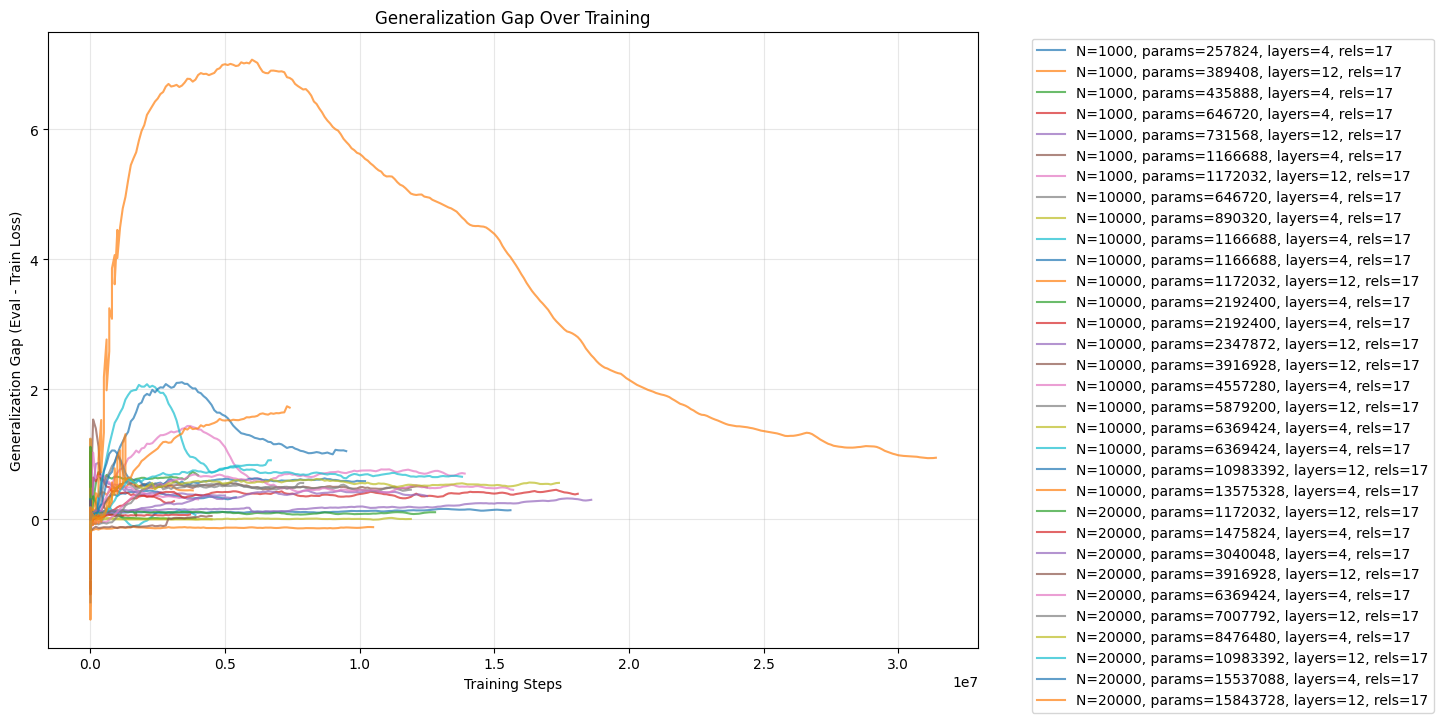

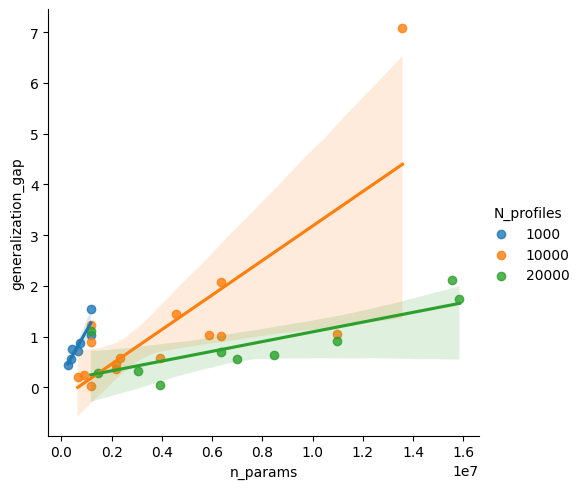

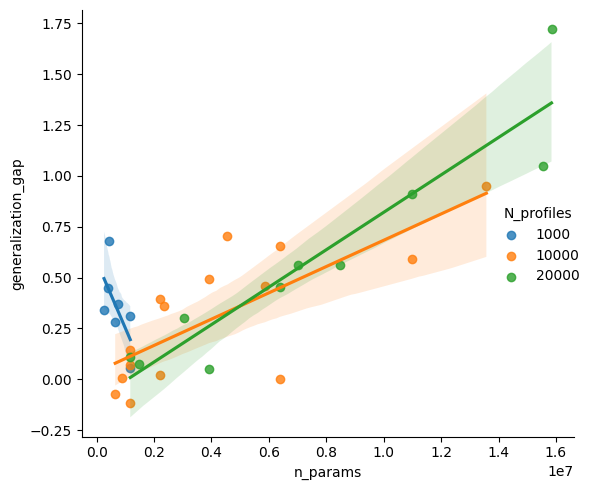

In [65]:

commmit_hashes = [
    '2a8bb77',
    '40e1da8',
    '344bde1',
    'ecb2fdc',
    'no_git'
]

eval_results = load_eval_results(
    skip_mode=False,
    subjectwise=False,
    commit_hashes=commmit_hashes
)


eval_results = eval_results[
    (eval_results['mode'].isin(['train_twohop', 'eval_complete_two_hop_questions']))
]

# Create plot
plot_generalization_gap(eval_results)

In [34]:
evaluation_results = eval_results[eval_results['mode'] == 'eval_complete_two_hop_questions']
training_results = eval_results[eval_results['mode'] == 'train_twohop']

combined_results = pd.merge(evaluation_results, training_results, on=[
    'hops', 
    'global_step',
    'N_profiles', 
    'n_params', 
    'layers', 
    'relations', 
    'max_train_hops',
    'parameter_l2',
    'min_train_hops',
    'commit_hash',
    'currency',
    'lr',
    'weight_decay',
    'hop_ratio',
    'optimizer'
    ], suffixes=('_eval', '_train'))

combined_results = combined_results[~pd.isna(combined_results['loss_eval']) & ~pd.isna(combined_results['loss_train'])]

combined_results['generalization_gap'] = combined_results['loss_eval'] - combined_results['loss_train']

combined_results['generalization_gap']


0       0.309163
1       0.306593
2       0.230204
3       0.149069
4       0.112686
          ...   
3435   -0.124676
3436   -0.120747
3437   -0.116693
3438   -0.116630
3439   -0.118421
Name: generalization_gap, Length: 3440, dtype: float64

In [59]:
parameter_trend_data = combined_results.groupby([
                'hops', 
                'N_profiles', 
                'n_params', 
                'layers', 
                'max_train_hops',
                'commit_hash',
                ])['generalization_gap'].max().reset_index()

parameter_trend_data

,hops,N_profiles,n_params,layers,max_train_hops,commit_hash,generalization_gap
0,2,1000,257824,4,2,ecb2fdc,0.444013
1,2,1000,389408,12,2,40e1da8,0.556121
2,2,1000,435888,4,2,ecb2fdc,0.749194
3,2,1000,646720,4,2,ecb2fdc,0.719030
4,2,1000,731568,12,2,ecb2fdc,0.871927
5,2,1000,1166688,4,2,40e1da8,1.537079
6,2,1000,1172032,12,2,ecb2fdc,1.028801
7,2,10000,646720,4,2,no_git,0.197774
8,2,10000,890320,4,2,2a8bb77,0.244434
9,2,10000,1166688,4,2,40e1da8,1.230283


In [36]:
combined_results[combined_results['generalization_gap'] == combined_results['generalization_gap'].min()]

,loss_eval,global_step,mode_eval,parameter_l2,hops,N_profiles,n_params,min_train_hops,max_train_hops,weight_decay,...,beta1_eval,optimizer,relations,hop_ratio,commit_hash,currency,loss_train,mode_train,beta1_train,generalization_gap
726,48.665806,100,eval_complete_two_hop_questions,0.02509,2,20000,15843728,1,2,0.1,...,0.99,sf,17,None,344bde1,current,50.207666,train_twohop,0.99,-1.541861
